In [14]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import sys
print(sys.executable)
sys.path.insert(1, '../src/')
from config import raw_data_path, univariate_data_path, processed_data_path, models_path
from preprocessing_modules import create_time_windows_with_labels, create_time_windows_with_metadata
from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
import matplotlib.pyplot as plt
from FCMAE_model import FCMAE
from tsai.models.ResNet import ResNet
from tsai.models import ResNet
from tsai.models.ResNet import ResNet
from fastai.metrics import accuracy
from fastai.data.core import DataLoaders
from fastai.learner import Learner
import torch


/home/nwertheim/miniconda3/bin/python


In [15]:
# Define FCMAE Hyperparameters:
batch_size = 16
num_blocks = 5
kernel_size = 7
base_dim = 32
learning_rate_FCMAE = 0.00016938000495408888
input_dimension = 512

# ResNet classification head hyperparameters (ADAM)
learning_rate = 1.582887649804575e-04

In [16]:

'''MY DATA + class weights'''
train_dir = os.path.join(univariate_data_path, "target_univariate_no_PCA_train_2.npy")
train_data = np.load(train_dir, allow_pickle=True)
# train_data = pd.DataFrame(train_data)
test_dir = os.path.join(univariate_data_path, "target_univariate_no_PCA_test_2.npy")
test_data = np.load(test_dir, allow_pickle=True)
# test_data = pd.DataFrame(test_data)
print(len(train_data))
print(len(test_data))
print(train_data[0])
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.utils.class_weight import compute_class_weight
from fastai.losses import CrossEntropyLossFlat
from fastai.optimizer import SGD
from torch.optim import AdamW
from functools import partial
from fastai.optimizer import OptimWrapper
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from fastai.data.core import DataLoaders



from collections import Counter

train_windows, train_labels, train_meta = create_time_windows_with_metadata(train_data)
test_windows, test_labels, test_meta = create_time_windows_with_metadata(test_data)

# Convert to tensors
train_windows_tensor = torch.tensor(train_windows, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.float32)
test_windows_tensor = torch.tensor(test_windows, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.float32)

train_windows_tensor = train_windows_tensor.unsqueeze(1)  # (1071, 1, 12000)
test_windows_tensor = test_windows_tensor.unsqueeze(1)    # (899, 1, 12000)

train_labels_tensor = train_labels_tensor.long()
test_labels_tensor = test_labels_tensor.long()


print(train_labels_tensor.shape)

train_dataset = TensorDataset(train_windows_tensor, train_labels_tensor)
test_dataset = TensorDataset(test_windows_tensor, test_labels_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
# Test metadata for reference
test_meta = test_meta
print('batch size', batch_size)
dls = DataLoaders(train_loader, test_loader)


# Calculate class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

744
192
{'record_name': 'Hopper-2024_11_03_14_13_16-0000010179-0002-chan0', 'signal': array([[ 0.70569938],
       [ 1.58579907],
       [ 1.22047813],
       ...,
       [-0.30476434],
       [-0.16021862],
       [-0.40381152]]), 'fs': 20, 'preterm': 1}
torch.Size([9900])
batch size 16


In [17]:



# Load the pre-trained encoder
path = os.path.join(models_path, 'FCMAE_encoder_no_PCA_gpu_normalized_correct.pth')

# Load the full FCMAE model
fcmae = FCMAE(in_channels=1, base_dim=base_dim, num_blocks=num_blocks, kernel_size=kernel_size)


# Load the saved weights into the full model
state_dict = torch.load(path)
fcmae.load_state_dict(state_dict)

# Extract only the encoder from the FCMAE model
encoder = fcmae.encoder
# Set the encoder to evaluation mode and freeze the encoder parameters
encoder.eval()
for param in encoder.parameters():
    param.requires_grad = False  # Freeze the encoder

print(encoder)

Sequential(
  (0): Conv1d(1, 32, kernel_size=(7,), stride=(2,), padding=(3,))
  (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv1d(32, 64, kernel_size=(7,), stride=(2,), padding=(3,))
  (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): Conv1d(64, 128, kernel_size=(7,), stride=(2,), padding=(3,))
  (7): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU()
  (9): Conv1d(128, 256, kernel_size=(7,), stride=(2,), padding=(3,))
  (10): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU()
  (12): Conv1d(256, 512, kernel_size=(7,), stride=(2,), padding=(3,))
  (13): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): ReLU()
)



🌀 Run 1/5


epoch,train_loss,valid_loss,accuracy,time



🌀 Run 2/5


epoch,train_loss,valid_loss,accuracy,time
0,0.673949,0.638620,0.559896,00:04
1,0.655985,0.782659,0.482292,00:04
2,0.670818,0.902331,0.430208,00:04
3,0.668843,0.913019,0.369271,00:04
4,0.663188,0.722147,0.500000,00:04
5,0.665172,0.796463,0.494792,00:04
6,0.647664,0.761322,0.417188,00:04
7,0.637016,1.090913,0.429688,00:04
8,0.620831,0.770296,0.485938,00:04
9,0.638359,1.042879,0.357812,00:04



🌀 Run 3/5


epoch,train_loss,valid_loss,accuracy,time
0,0.679550,0.697060,0.461979,00:04
1,0.669535,0.841218,0.533854,00:04
2,0.667012,0.720004,0.550000,00:04
3,0.656712,0.831133,0.395833,00:04
4,0.650790,1.074200,0.357812,00:04
5,0.649226,0.853532,0.395833,00:04
6,0.656718,0.909376,0.460417,00:04
7,0.651504,1.043437,0.321354,00:04
8,0.640414,1.076488,0.400521,00:04
9,0.644738,1.064799,0.365625,00:04



🌀 Run 4/5


epoch,train_loss,valid_loss,accuracy,time
0,0.673978,0.678253,0.546354,00:04
1,0.670607,0.688585,0.493750,00:04
2,0.667760,0.836278,0.367708,00:04
3,0.664943,0.834220,0.363542,00:04
4,0.648940,1.027874,0.487500,00:04
5,0.664886,0.911460,0.421354,00:04
6,0.660843,0.970950,0.468750,00:04
7,0.654751,0.824217,0.490104,00:04
8,0.642679,1.066187,0.485938,00:04
9,0.639782,1.192250,0.414062,00:04



🌀 Run 5/5


epoch,train_loss,valid_loss,accuracy,time
0,0.667696,0.658670,0.581771,00:04
1,0.676192,0.768987,0.453125,00:04
2,0.673159,0.783643,0.379167,00:04
3,0.657684,0.898367,0.463542,00:04
4,0.660222,0.962196,0.397917,00:04
5,0.658403,1.052650,0.359896,00:04
6,0.643454,0.820067,0.478646,00:04
7,0.656117,1.196801,0.399479,00:04
8,0.638223,0.976123,0.501042,00:04
9,0.647639,0.960903,0.336979,00:04



📊 Final Evaluation:
Accuracy: 0.4141 ± 0.0273
Precision: 0.7639 ± 0.0253
Recall: 0.3701 ± 0.0342
F1 Score: 0.4979 ± 0.0341
AP: 0.7887 ± 0.0234
AUC: 0.4431 ± 0.0441


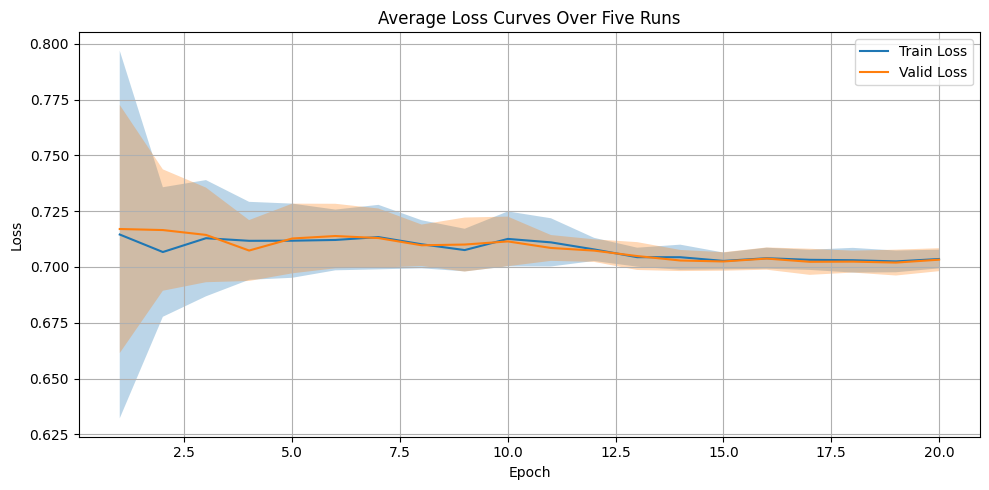

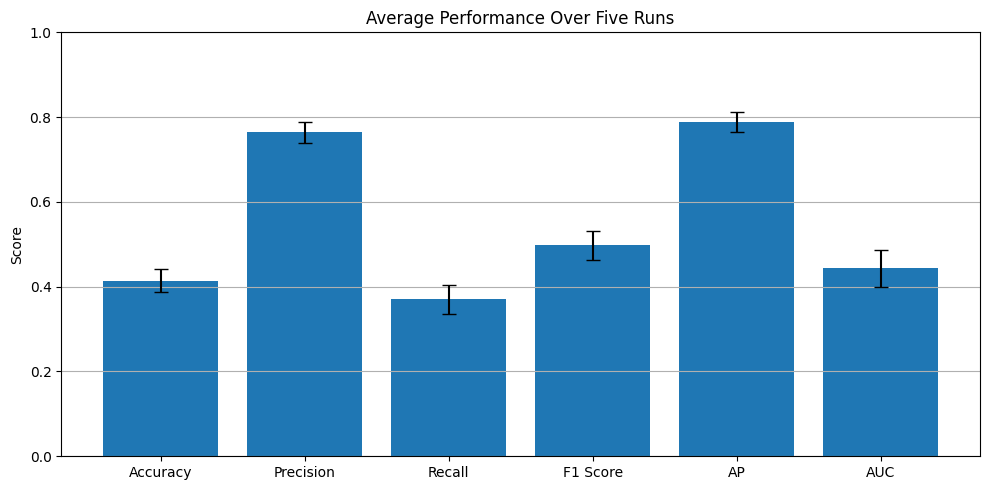

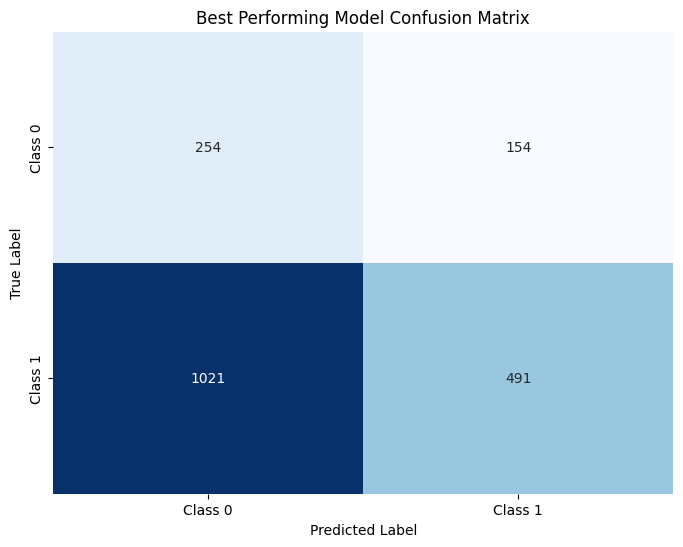

In [18]:
import numpy as np
import torch
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, average_precision_score, roc_auc_score,
    confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from fastai.learner import Learner
from fastai.optimizer import SGD
from fastai.metrics import accuracy
from tsai.data.core import DataLoaders

class FCMAEClassifier(nn.Module):
    def __init__(self, encoder):
        super().__init__()
        self.encoder = encoder
        self.classifier = ResNet(input_dimension, 2)  

    def forward(self, x):
        with torch.no_grad():  # freeze encoder
            x = self.encoder(x)
        return self.classifier(x)

# ----------------------------- Utility Functions -----------------------------
def seed_everything(seed):
    import random, os
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


# ----------------------------- Experiment Setup -----------------------------
num_epochs = 20
num_runs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

all_train_losses = []
all_valid_losses = []
all_metrics = []

best_ap = -1
best_preds = None
best_targs = None

all_pred_labels = []
all_pred_probs = []

loss_func = torch.nn.CrossEntropyLoss(weight=class_weights_tensor) 



for run in range(num_runs):
    print(f"\n🌀 Run {run+1}/{num_runs}")
    seed_everything(run)

    model = FCMAEClassifier(encoder).to(device)

    learn = Learner(dls, model, loss_func=loss_func, metrics=accuracy)
    learn.model.to(device)

    learn.fit_one_cycle(num_epochs, learning_rate)

    # Record losses
    losses = np.array(learn.recorder.losses)
    iters_per_epoch = len(dls.train)
    train_loss = losses[::2][:num_epochs]
    valid_loss = losses[1::2][:num_epochs]
    all_train_losses.append(train_loss)
    all_valid_losses.append(valid_loss)

    # Predictions
    preds, targs = learn.get_preds(dl=dls.valid)
    pred_labels = preds.argmax(dim=1)
    pred_probs = preds[:, 1].cpu().numpy()
    true_labels = targs.cpu().numpy()

    all_pred_labels.append(pred_labels.cpu().numpy())
    all_pred_probs.append(pred_probs)

    # Evaluation metrics
    acc = accuracy_score(true_labels, pred_labels)
    prec = precision_score(true_labels, pred_labels, zero_division=0)
    rec = recall_score(true_labels, pred_labels, zero_division=0)
    f1 = f1_score(true_labels, pred_labels, zero_division=0)
    ap = average_precision_score(true_labels, pred_probs)
    auc = roc_auc_score(true_labels, pred_probs)
    all_metrics.append([acc, prec, rec, f1, ap, auc])

    if ap > best_ap:
        best_ap = ap
        best_preds = preds
        best_targs = true_labels

# ----------------------------- Post-Processing -----------------------------
all_train_losses = np.stack(all_train_losses)
all_valid_losses = np.stack(all_valid_losses)
all_metrics = np.stack(all_metrics)

# Average + std metrics
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AP', 'AUC']
mean_metrics = all_metrics.mean(axis=0)
std_metrics = all_metrics.std(axis=0)

print("\n📊 Final Evaluation:")
for name, mean, std in zip(metric_names, mean_metrics, std_metrics):
    print(f"{name}: {mean:.4f} ± {std:.4f}")

# Save predictions
pred_labels = best_preds.argmax(dim=1).cpu().numpy()
pred_probs = torch.softmax(best_preds, dim=1)[:, 1].cpu().numpy()

# Assuming `test_meta` has the record_name and window_index
window_ids = [entry['record_name'] + '-' + str(entry['window_index']) for entry in test_meta]
final_df = pd.DataFrame({
    'window_id': window_ids,
    'best_pred_label': pred_labels,
    'best_pred_prob': pred_probs,
    'target': best_targs
})

for run_idx, (labels, probs) in enumerate(zip(all_pred_labels, all_pred_probs), start=1):
    final_df[f'pred_label{run_idx}'] = labels
    final_df[f'pred_prob{run_idx}'] = probs

final_df.to_csv("results_FCMAE_resnet_ADAM.csv", index=False)

# ----------------------------- Plot Loss Curves -----------------------------
epochs = np.arange(1, num_epochs + 1)
plt.figure(figsize=(10, 5))

mean_train = all_train_losses.mean(axis=0)
std_train = all_train_losses.std(axis=0)
plt.plot(epochs, mean_train, label='Train Loss')
plt.fill_between(epochs, mean_train - std_train, mean_train + std_train, alpha=0.3)

mean_valid = all_valid_losses.mean(axis=0)
std_valid = all_valid_losses.std(axis=0)
plt.plot(epochs, mean_valid, label='Valid Loss')
plt.fill_between(epochs, mean_valid - std_valid, mean_valid + std_valid, alpha=0.3)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Average Loss Curves Over Five Runs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ----------------------------- Plot Metrics -----------------------------
plt.figure(figsize=(10, 5))
plt.bar(metric_names, mean_metrics, yerr=std_metrics, capsize=5)
plt.title('Average Performance Over Five Runs')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# ----------------------------- Confusion Matrix -----------------------------
cm = confusion_matrix(best_targs, pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Best Performing Model Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


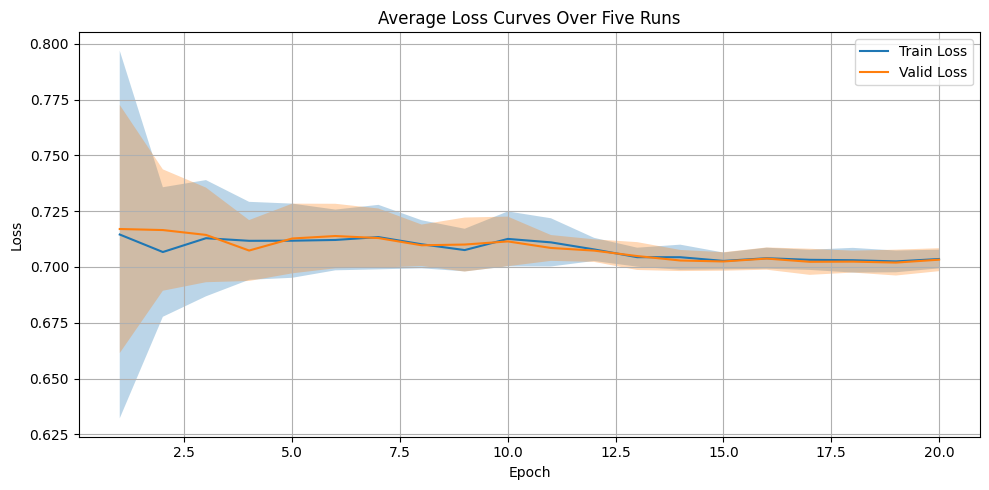

In [19]:
epochs = np.arange(1, num_epochs + 1)
plt.figure(figsize=(10, 5))

mean_train = all_train_losses.mean(axis=0)
std_train = all_train_losses.std(axis=0)
plt.plot(epochs, mean_train, label='Train Loss')
plt.fill_between(epochs, mean_train - std_train, mean_train + std_train, alpha=0.3)

mean_valid = all_valid_losses.mean(axis=0)
std_valid = all_valid_losses.std(axis=0)
plt.plot(epochs, mean_valid, label='Valid Loss')
plt.fill_between(epochs, mean_valid - std_valid, mean_valid + std_valid, alpha=0.3)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Average Loss Curves Over Five Runs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()